# AI Powered Multi-Agent Deal Finder

1. This notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
from items import Item

In [6]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [ ]:
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf_model.fit(vectors, prices)

import psutil, joblib
from contextlib import contextmanager
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

phys = psutil.cpu_count(logical=False) or psutil.cpu_count(logical=True)
n_jobs = max(1, phys - 1)

@contextmanager
def tqdm_joblib(tqdm_object):
    """Patch joblib to report into tqdm progress bar."""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=n_jobs, random_state=42)

# One progress bar tick ≈ one tree (works via joblib under the hood)
with tqdm_joblib(tqdm(total=rf_model.n_estimators, desc="Training RandomForest")):
    rf_model.fit(vectors, prices)


Training RandomForest:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [11]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [12]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [13]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [14]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [15]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $296.33 Truth: $374.41 Error: $78.08 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $182.69 Truth: $225.11 Error: $42.42 SLE: 0.04 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $205.22 Truth: $61.68 Error: $143.54 SLE: 1.42 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $395.89 Truth: $599.99 Error: $204.10 SLE: 0.17 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $222.88 Truth: $16.99 Error: $205.89 SLE: 6.36 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $53.19 Truth: $31.99 Error: $21.20 SLE: 0.25 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $268.39 Truth: $101.79 Error: $166.60 SLE: 0.93 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $247.58 Truth: $289.00 Error: $41.42 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $310.53 Truth: $635.86 Error: $325.33 SLE: 0.51 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $181.71 Truth: $65.99 Error: $115.72 SLE

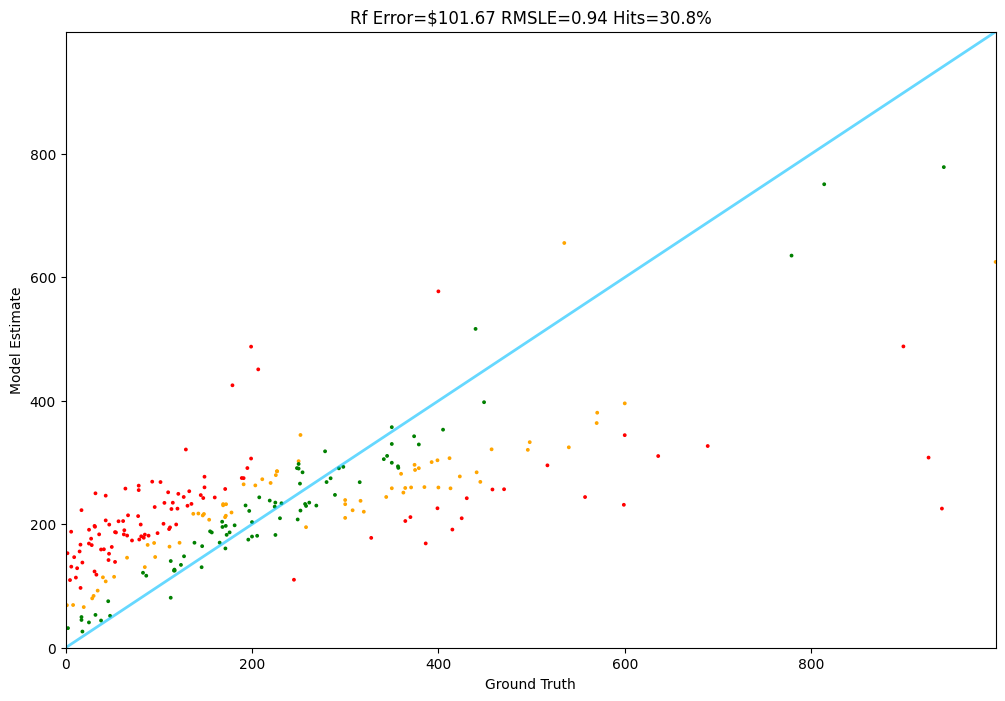

In [16]:
Tester.test(rf, test)

In [17]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [19]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
281.43740000000014


In [20]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [22]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.08
Frontier: 0.64
RandomForest: -0.27
Min: 0.23
Max: 0.27
Intercept=27.80


In [23]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [24]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [25]:
ensemble.price(product)

211.89027696695254

In [26]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $324.87 Truth: $374.41 Error: $49.54 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $200.85 Truth: $225.11 Error: $24.26 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $71.33 Truth: $61.68 Error: $9.65 SLE: 0.02 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $378.69 Truth: $599.99 Error: $221.30 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $47.16 Truth: $16.99 Error: $30.17 SLE: 0.97 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $38.29 Truth: $31.99 Error: $6.30 SLE: 0.03 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $98.51 Truth: $101.79 Error: $3.28 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $406.34 Truth: $289.00 Error: $117.34 SLE: 0.12 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $646.52 Truth: $635.86 Error: $10.66 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $81.14 Truth: $65.99 Error: $15.15 SLE: 0.04 Item

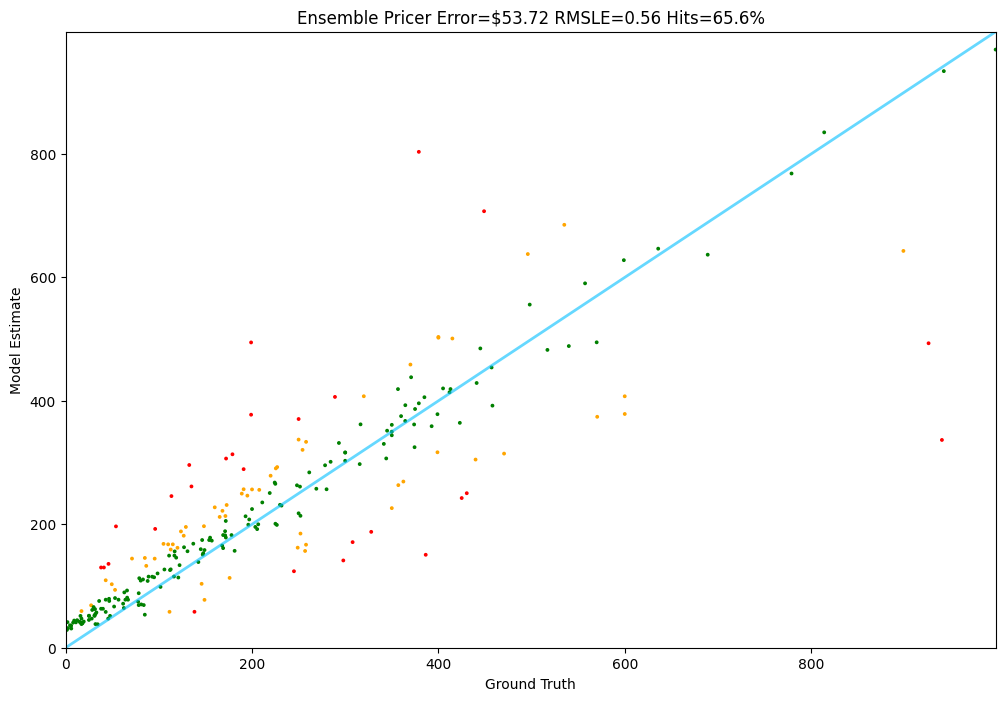

In [27]:
Tester.test(ensemble_pricer, test)